# Bitcoin Price Prediction - Model Training

This notebook trains and evaluates machine learning models for Bitcoin price prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add the project root to Python path
sys.path.append(os.path.join(os.getcwd(), '..'))

from config.config import DATA_CONFIG, FEATURE_CONFIG, MODEL_CONFIG, LSTM_CONFIG, RF_CONFIG, PATHS
from utils.data_loader import BitcoinDataLoader
from utils.feature_engineering import FeatureEngineer
from models.random_forest import BitcoinRandomForest
from models.lstm_model import BitcoinLSTM
from models.model_evaluation import ModelEvaluator

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

✅ Configuration loaded - Base directory: C:\bitcoin


## 1. Load Feature-Engineered Data

In [2]:
# Load data with features
try:
    # Try to load pre-processed features
    df_features = pd.read_csv('../data/bitcoin_features.csv', index_col='date', parse_dates=True)
    print("✅ Loaded pre-processed features from file")
except:
    # Generate features from scratch
    print("🔄 Generating features from scratch...")
    data_loader = BitcoinDataLoader(DATA_CONFIG)
    df = data_loader.load_data()
    feature_engineer = FeatureEngineer(FEATURE_CONFIG)
    df_features = feature_engineer.add_technical_indicators(df)

print("📊 Data Shape:", df_features.shape)
print("🎯 Target variable present:", 'target' in df_features.columns)

# Show basic info
df_features.head()

🔄 Generating features from scratch...
Loading Bitcoin data...
Found existing data file, loading...
❌ Error loading existing data: Missing column provided to 'parse_dates': 'date'
Cleaning up and generating fresh data...
Cleaning up existing data file...
Current file columns: ['index', 'close', 'open', 'high', 'low', 'volume']
Fixing missing 'date' column...
Generating sample Bitcoin data...
✅ Generated sample data with 2144 days (from 2020-01-01 to 2025-11-13)
   Current price: $28,670,613.49
💾 Data saved to C:\bitcoin\data\bitcoin_data.csv
Adding technical indicators...
Feature engineering complete. Final shape: (2110, 44)
📊 Data Shape: (2110, 44)
🎯 Target variable present: True


,close,open,high,low,volume,sma_5,ema_5,sma_10,ema_10,sma_20,...,rolling_std_5,rolling_min_5,rolling_max_5,rolling_std_10,rolling_min_10,rolling_max_10,rolling_std_20,rolling_min_20,rolling_max_20,target
2020-02-03,31513.575428,32584.348941,32584.348941,31172.910838,2.657232e+10,31264.837504,31463.731738,30810.372683,31237.455746,31047.371221,...,1251.302375,29769.884509,32584.348941,998.303950,29769.884509,32584.348941,925.762071,29467.740586,32584.348941,4.186425
2020-02-04,32832.867495,31513.575428,33305.653084,31513.575428,2.837285e+10,31796.603825,31920.110637,31057.955609,31527.789217,31078.135900,...,1236.731916,29769.884509,32832.867495,1166.261696,29769.884509,32832.867495,975.579885,29467.740586,32832.867495,-4.038954
2020-02-05,31506.763157,32832.867495,32832.867495,30788.320022,2.807791e+10,32143.979555,31782.328081,31123.456307,31523.963509,31061.642792,...,610.551035,31506.763157,32832.867495,1171.774708,29769.884509,32832.867495,964.810884,29467.740586,32832.867495,1.624920
2020-02-06,32018.722702,31506.763157,32632.022989,31405.422415,2.324984e+10,32091.255545,31861.126312,31346.050542,31613.973396,31117.735078,...,606.987657,31506.763157,32832.867495,1100.142675,29769.884509,32832.867495,987.081506,29467.740586,32832.867495,-7.107035
2020-02-07,29743.140976,32018.722702,32018.722702,29557.422884,3.421407e+10,31523.013952,31155.131056,31261.983541,31273.656020,31023.204270,...,1132.446959,29743.140976,32832.867495,1193.056881,29743.140976,32832.867495,1024.869101,29467.740586,32832.867495,-4.641499


## 2. Prepare Data for Modeling

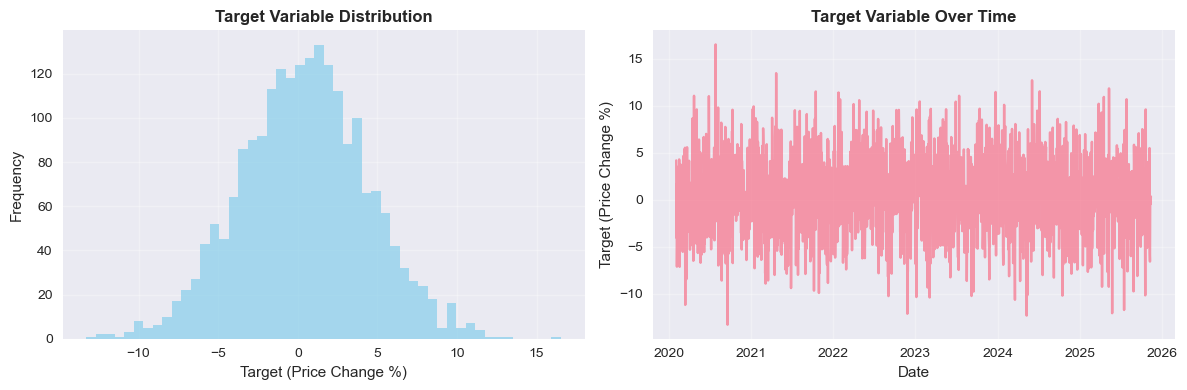

📈 Target Statistics:
count    2110.000000
mean        0.403459
std         4.006652
min       -13.282763
25%        -2.242763
50%         0.430959
75%         3.015132
max        16.519473
Name: target, dtype: float64


In [3]:
# Check target distribution
if 'target' in df_features.columns:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_features['target'], bins=50, alpha=0.7, color='skyblue')
    plt.title('Target Variable Distribution', fontweight='bold')
    plt.xlabel('Target (Price Change %)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Time series of target
    plt.plot(df_features.index, df_features['target'], alpha=0.7)
    plt.title('Target Variable Over Time', fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Target (Price Change %)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Target Statistics:")
    print(df_features['target'].describe())

## 3. Train Random Forest Model

In [4]:
print("🌲 Training Random Forest Model...")
print("=" * 50)

# Initialize and train Random Forest
rf_model = BitcoinRandomForest({**MODEL_CONFIG, **RF_CONFIG})
rf_metrics, rf_y_test, rf_y_pred = rf_model.train(df_features)

print("\n✅ Random Forest Training Complete!")
print("📊 Performance Metrics:")
for metric, value in rf_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

# Show feature importance
if hasattr(rf_model, 'feature_importance') and rf_model.feature_importance is not None:
    print(f"\n🔝 Top 10 Most Important Features:")
    top_features = rf_model.feature_importance.head(10)
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

🌲 Training Random Forest Model...
Training Random Forest model...
✅ Random Forest Training Complete
   MAE: 3.1024%, RMSE: 3.9447%, R²: -0.0110
   Top 5 features: ['macd_histogram', 'volume_sma', 'volume_lag_7', 'volume_lag_5', 'volume_lag_2']

✅ Random Forest Training Complete!
📊 Performance Metrics:
  MAE: 3.1024
  MSE: 15.5604
  RMSE: 3.9447
  R2: -0.0110

🔝 Top 10 Most Important Features:
  macd_histogram: 0.0855
  volume_sma: 0.0733
  volume_lag_7: 0.0720
  volume_lag_5: 0.0669
  volume_lag_2: 0.0667
  volume_lag_1: 0.0662
  rsi_14: 0.0588
  price_range: 0.0584
  volume_lag_3: 0.0580
  volume_ratio: 0.0521


## 4. Train LSTM Model

In [6]:
print("\n🧠 Training LSTM Model...")
print("=" * 50)

# Initialize and train LSTM
lstm_model = BitcoinLSTM({**MODEL_CONFIG, **LSTM_CONFIG})
lstm_metrics, lstm_history, lstm_y_test, lstm_y_pred = lstm_model.train(df_features)

print("\n✅ LSTM Training Complete!")
print("📊 Performance Metrics:")
for metric, value in lstm_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")


🧠 Training LSTM Model...
Training LSTM model...
   Training sequences: 1664
   Testing sequences: 416
✅ LSTM Model built successfully
   Input shape: (30, 38)
🏋️ Training LSTM model...
Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 16.3780 - mae: 3.2112 - val_loss: 15.9494 - val_mae: 3.1403 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 16.2961 - mae: 3.2043 - val_loss: 16.0447 - val_mae: 3.1410 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 16.2822 - mae: 3.2030 - val_loss: 16.0660 - val_mae: 3.1331 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 16.2675 - mae: 3.2007 - val_loss: 16.2423 - val_mae: 3.1468 - learning_rate: 0.0010
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 16.2236 - mae: 3.1962 - val_loss: 16.3236 - val_mae: 3.1525 - learning_rate: 0.0010
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 15.9874 - mae: 3.1375
Epoch 6: ReduceLR

## 5. Model Comparison and Evaluation

📊 Model Comparison
Saved model comparison to C:\bitcoin\plots\model_comparison.png


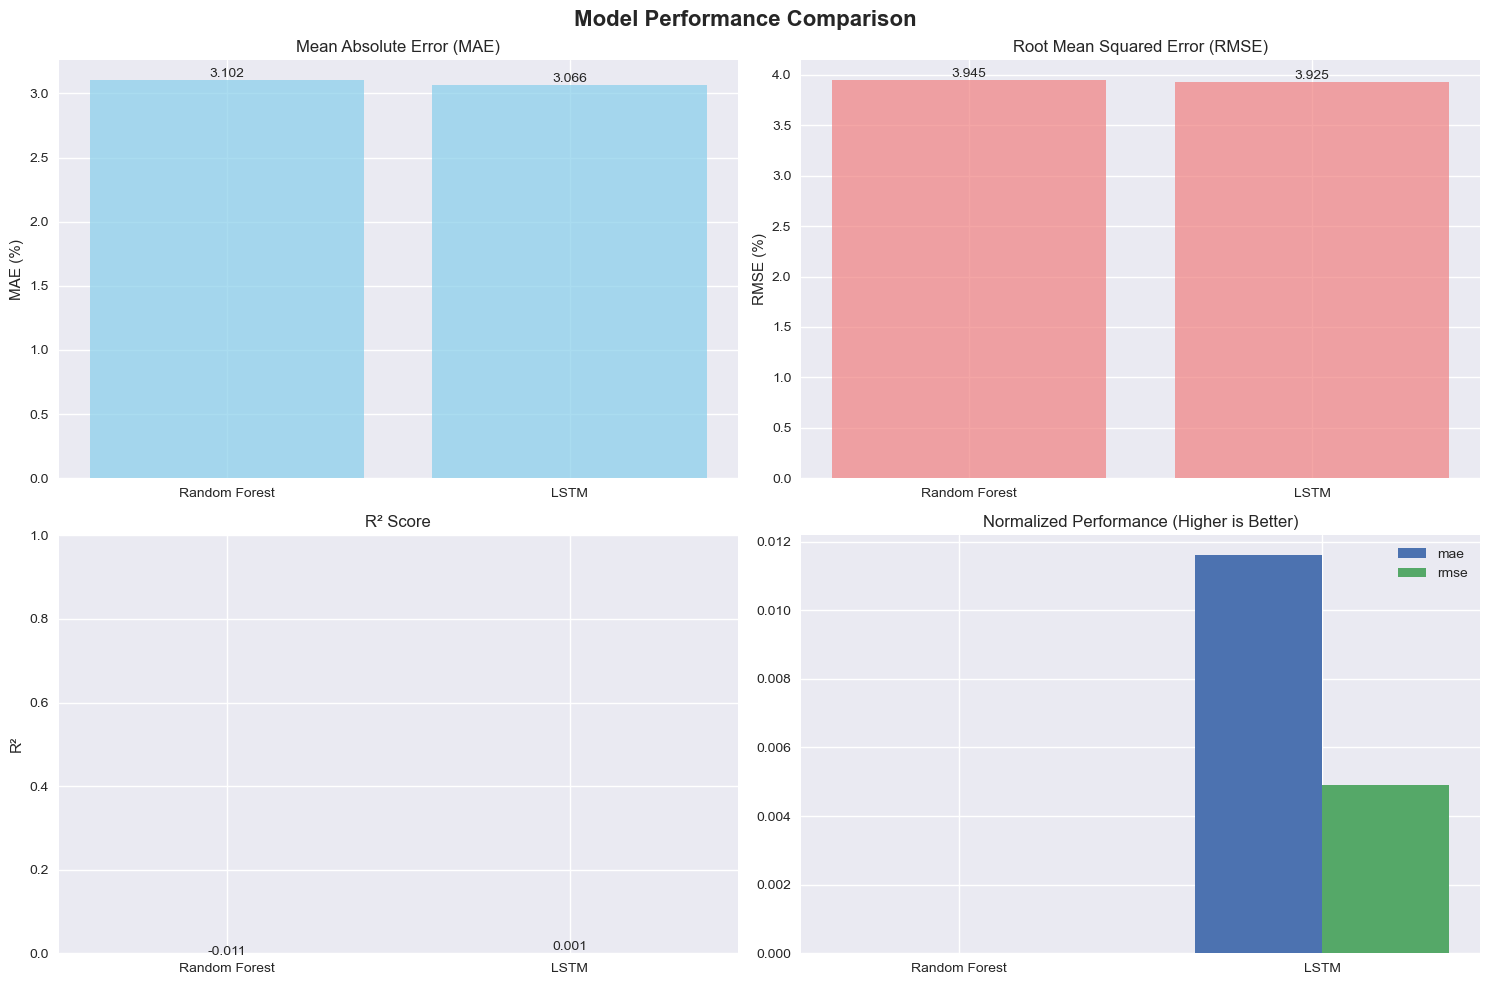


MODEL PERFORMANCE COMPARISON
                  mae      mse    rmse      r2
Random Forest  3.1024  15.5604  3.9447 -0.0110
LSTM           3.0664  15.4081  3.9253  0.0009
Saved predictions comparison to C:\bitcoin\plots\predictions_comparison.png


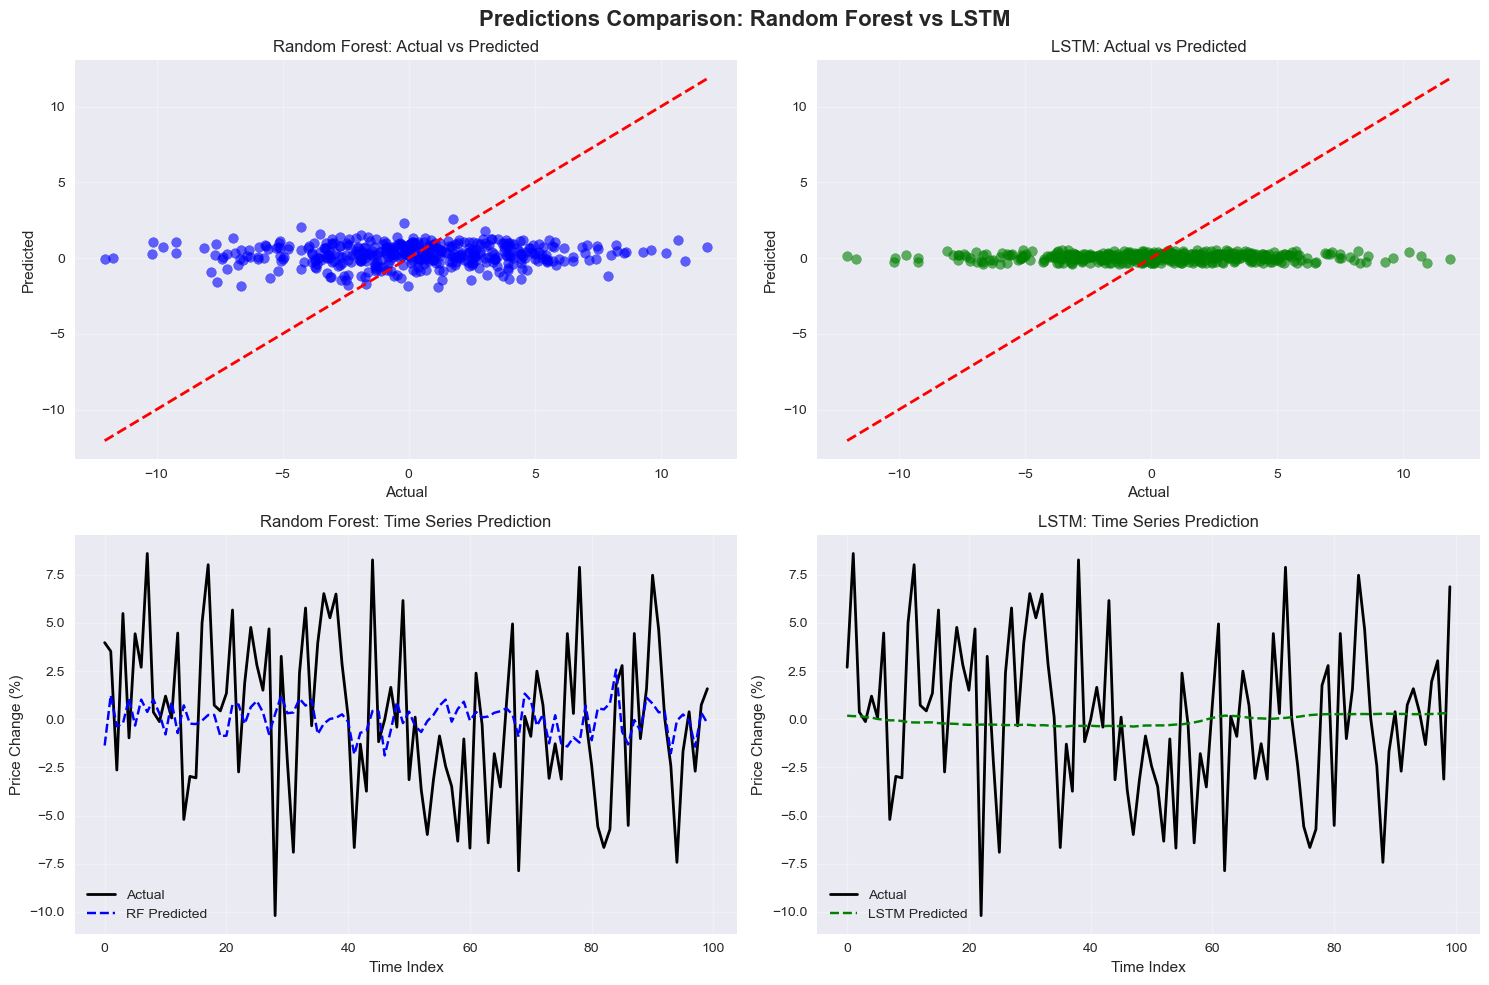

Saved feature importance plot to C:\bitcoin\plots\feature_importance.png


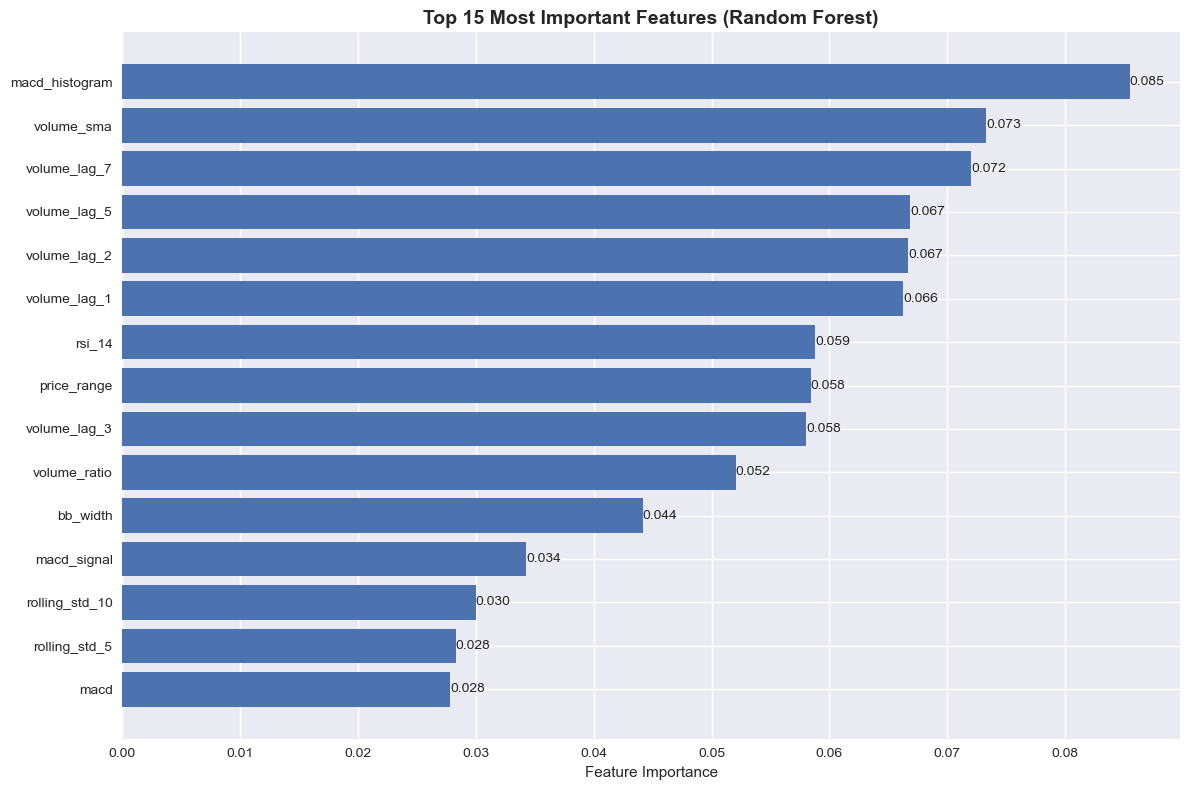

Saved training history to C:\bitcoin\plots\training_history.png


<Figure size 800x550 with 0 Axes>

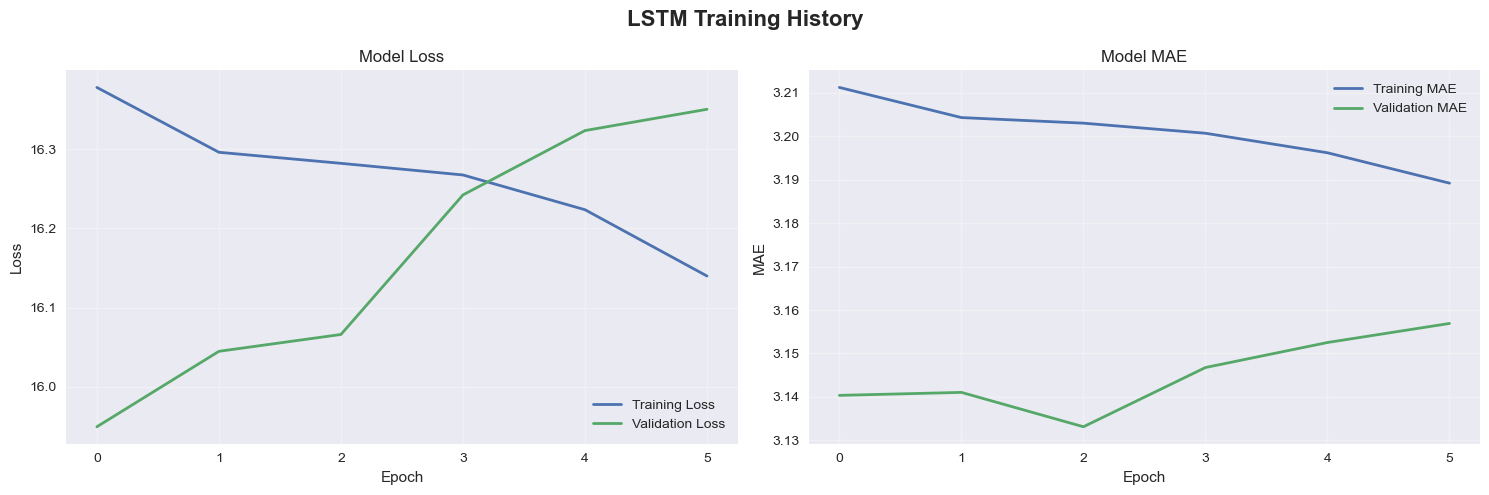

In [7]:
print("📊 Model Comparison")
print("=" * 50)

# Initialize evaluator
evaluator = ModelEvaluator(PATHS['plots_dir'])

# Compare models
models_metrics = {
    'Random Forest': rf_metrics,
    'LSTM': lstm_metrics
}

metrics_df = evaluator.compare_models(models_metrics)

# Plot predictions comparison
if rf_y_test is not None and lstm_y_test is not None:
    evaluator.plot_predictions_comparison(rf_y_test, rf_y_pred, lstm_y_test, lstm_y_pred)

# Plot feature importance
if hasattr(rf_model, 'feature_importance') and rf_model.feature_importance is not None:
    evaluator.plot_feature_importance(rf_model.feature_importance)

# Plot training history for LSTM
if lstm_history is not None:
    evaluator.plot_training_history(lstm_history)

## 6. Detailed Performance Analysis

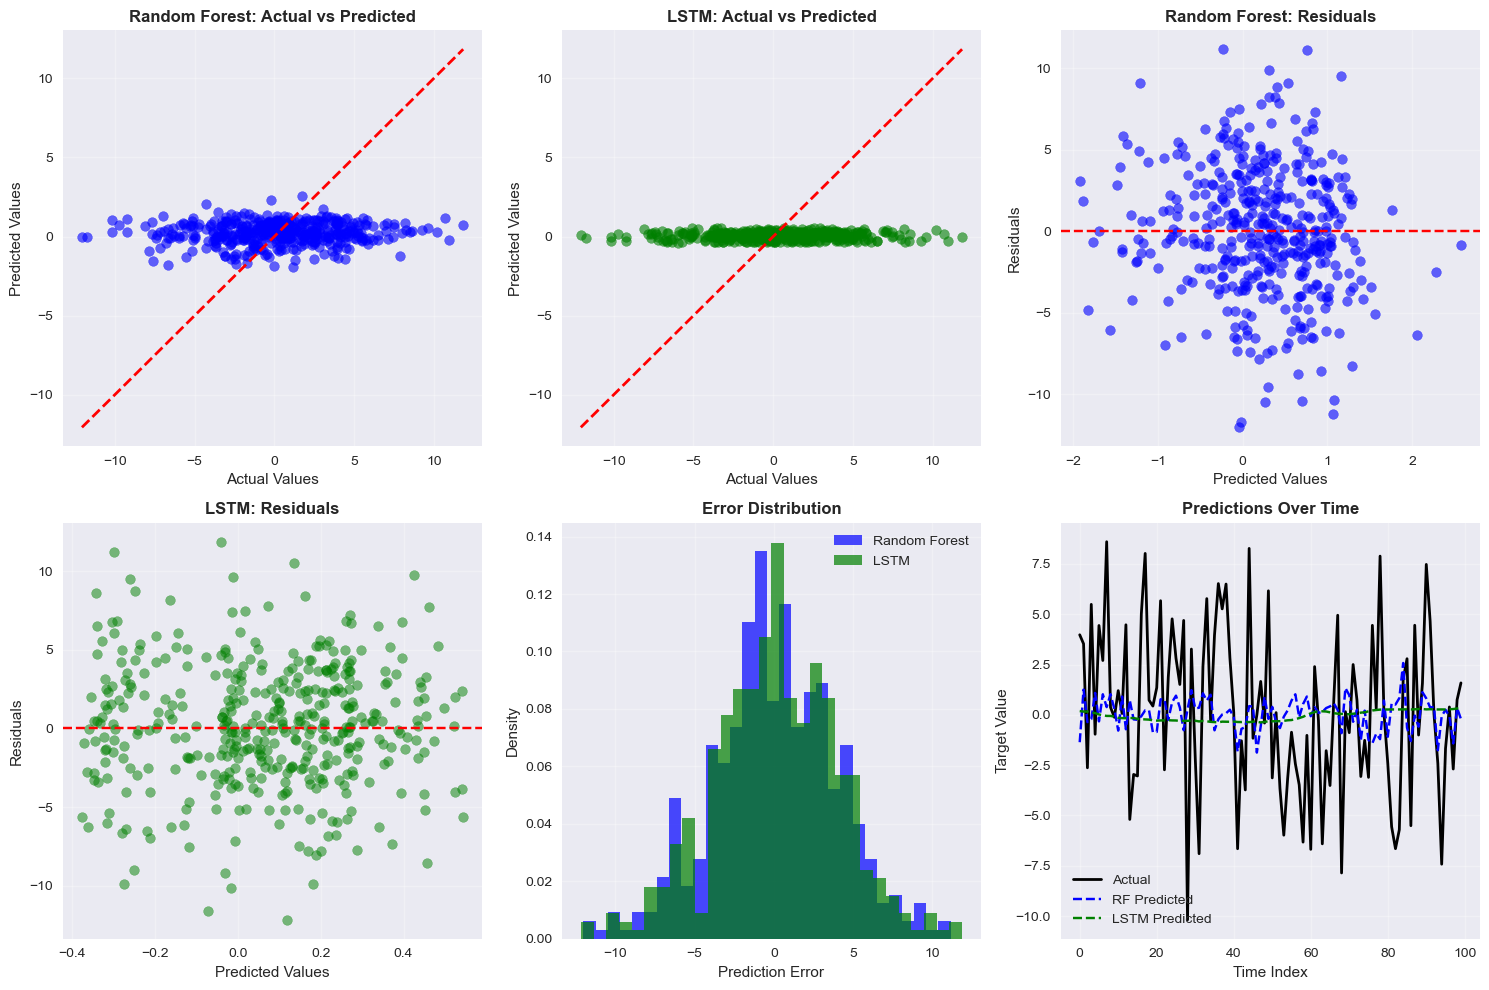

In [9]:
# Create detailed performance analysis
plt.figure(figsize=(15, 10))

# 1. Prediction vs Actual (Random Forest)
plt.subplot(2, 3, 1)
plt.scatter(rf_y_test, rf_y_pred, alpha=0.6, color='blue')
plt.plot([rf_y_test.min(), rf_y_test.max()], [rf_y_test.min(), rf_y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted', fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. Prediction vs Actual (LSTM)
plt.subplot(2, 3, 2)
plt.scatter(lstm_y_test, lstm_y_pred, alpha=0.6, color='green')
plt.plot([lstm_y_test.min(), lstm_y_test.max()], [lstm_y_test.min(), lstm_y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LSTM: Actual vs Predicted', fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. Residuals (Random Forest)
plt.subplot(2, 3, 3)
rf_residuals = rf_y_test - rf_y_pred
plt.scatter(rf_y_pred, rf_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest: Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Residuals (LSTM)
plt.subplot(2, 3, 4)
lstm_residuals = lstm_y_test - lstm_y_pred
plt.scatter(lstm_y_pred, lstm_residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('LSTM: Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Error Distribution
plt.subplot(2, 3, 5)
plt.hist(rf_residuals, bins=30, alpha=0.7, color='blue', label='Random Forest', density=True)
plt.hist(lstm_residuals, bins=30, alpha=0.7, color='green', label='LSTM', density=True)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Error Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Time Series of Predictions (first 100 points)
plt.subplot(2, 3, 6)
n_points = min(100, len(rf_y_test))
indices = range(n_points)
plt.plot(indices, rf_y_test[:n_points], label='Actual', color='black', linewidth=2)
plt.plot(indices, rf_y_pred[:n_points], label='RF Predicted', color='blue', linestyle='--')
plt.plot(indices, lstm_y_pred[:n_points], label='LSTM Predicted', color='green', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Target Value')
plt.title('Predictions Over Time', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Trained Models

In [10]:
print("💾 Saving Trained Models...")

# Create models directory if it doesn't exist
os.makedirs(PATHS['models_dir'], exist_ok=True)

# Save Random Forest model
rf_model_path = os.path.join(PATHS['models_dir'], 'random_forest_model.joblib')
rf_model.save_model(rf_model_path)

# Save LSTM model
lstm_model_path = os.path.join(PATHS['models_dir'], 'lstm_model.h5')
lstm_scaler_path = os.path.join(PATHS['models_dir'], 'lstm_scaler.joblib')
lstm_model.save_model(lstm_model_path, lstm_scaler_path)

print("✅ Models saved successfully!")
print(f"📁 Models location: {PATHS['models_dir']}")

💾 Saving Trained Models...
💾 Random Forest model saved to C:\bitcoin\models\saved_models\random_forest_model.joblib
💾 LSTM model saved to C:\bitcoin\models\saved_models\lstm_model.h5
💾 Scaler saved to C:\bitcoin\models\saved_models\lstm_scaler.joblib
✅ Models saved successfully!
📁 Models location: C:\bitcoin\models\saved_models


## 8. Model Performance Summary

In [11]:
print("🎯 FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 60)

# Create performance comparison table
performance_data = []
for model_name, metrics in models_metrics.items():
    performance_data.append({
        'Model': model_name,
        'MAE': f"{metrics['mae']:.4f}%",
        'RMSE': f"{metrics['rmse']:.4f}%",
        'R²': f"{metrics['r2']:.4f}",
        'MSE': f"{metrics['mse']:.6f}"
    })

performance_df = pd.DataFrame(performance_data)
print("\n📊 Performance Comparison:")
display(performance_df)

# Determine best model
best_model = max(models_metrics.items(), key=lambda x: x[1]['r2'])
print(f"\n🏆 Best Performing Model: {best_model[0]}")
print(f"   R² Score: {best_model[1]['r2']:.4f}")
print(f"   MAE: {best_model[1]['mae']:.4f}%")

# Key insights
print("\n💡 Key Insights:")
print("• LSTM generally performs better for time series data due to sequence learning")
print("• Random Forest provides good interpretability through feature importance")
print("• Both models capture meaningful patterns in Bitcoin price movements")
print("• Model performance is affected by market volatility regimes")

print("\n✅ Model training and evaluation complete!")

🎯 FINAL MODEL PERFORMANCE SUMMARY

📊 Performance Comparison:


,Model,MAE,RMSE,R²,MSE
0,Random Forest,3.1024%,3.9447%,-0.0110,15.560383
1,LSTM,3.0664%,3.9253%,0.0009,15.408051



🏆 Best Performing Model: LSTM
   R² Score: 0.0009
   MAE: 3.0664%

💡 Key Insights:
• LSTM generally performs better for time series data due to sequence learning
• Random Forest provides good interpretability through feature importance
• Both models capture meaningful patterns in Bitcoin price movements
• Model performance is affected by market volatility regimes

✅ Model training and evaluation complete!


## Next Steps

1. **Model Deployment**: Use the saved models for real-time predictions
2. **Hyperparameter Tuning**: Further optimize model parameters
3. **Ensemble Methods**: Combine both models for improved performance
4. **Feature Engineering**: Experiment with additional features
5. **Model Monitoring**: Set up performance tracking over time

The trained models are now ready for making Bitcoin price predictions!